# ENSO_amplitude: Variability of SST Anomalies in the Central Equatorial Pacific  

Computes the standard deviation of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W) to evaluate the amplitude of variability in the central equatorial Pacific, a key characteristic of ENSO events.  

## Datasets Used for Amplitude Comparison  

The following reference datasets are used to evaluate the amplitude of ENSO-related SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, offering high-quality surface fluxes and anomalies tailored for tropical climate analysis.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A long-term reanalysis dataset reconstructing global atmospheric conditions using surface pressure observations.  
- **ERA-Interim (1979–2018)**: A high-resolution reanalysis product providing consistent estimates of atmospheric and surface variables.  
- **ERSSTv5 (1854–2018)**: A globally gridded dataset optimised for long-term SST anomaly analysis and ENSO studies.  
- **HadISST (1870–2018)**: A comprehensive dataset of historical SST and sea ice observations combined with reconstructions.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis dataset delivering improved global atmospheric and surface data.  

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris
import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
# import cftime

In [5]:
# diag level 2 & 3?
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')

    cube = axis_statistics(cube,axis='y', operator='mean')

    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube
def prepoc3(cube): # extents and no axis statistics
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -15., "end_latitude": 15.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube

## sst_std for diag 1
def prepoc_one(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **nino34_latext_region)
    # remove seasonal cycle
    cube = anomalies(cube, period='monthly')
    #detrend
    cube = area_statistics(cube, operator='mean')
    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube

    
def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [6]:
model_datasets_prep = {name: prepoc_one(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc_one(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

Text(0.75, 0.8, '* observation')

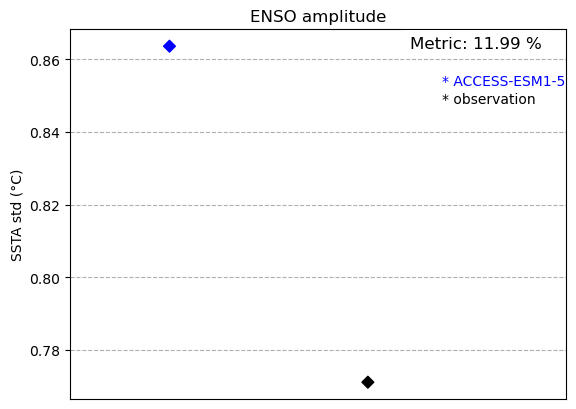

In [7]:
# plot
metric = [model_datasets_prep["ACCESS-ESM1-5"].data.item(), obs_datasets_prep["HadISST"].data.item()]

plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA std (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO amplitude')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)


Figure 1: Standard deviation of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), representing the amplitude of variability. The model amplitude is typically close to the reference but slightly weaker. Black markers indicate the reference data, while blue markers represent the model. The derived metric is the absolute relative difference, calculated as: 
abs
(
(
model
−
ref
)
/
ref
)
×
100
abs((model−ref)/ref)×100.

## Diagnostic Level 2

The second level shows the zonal structure of the ENSO amplitude: the standard deviation of the anomalies along the equator in the Pacific.

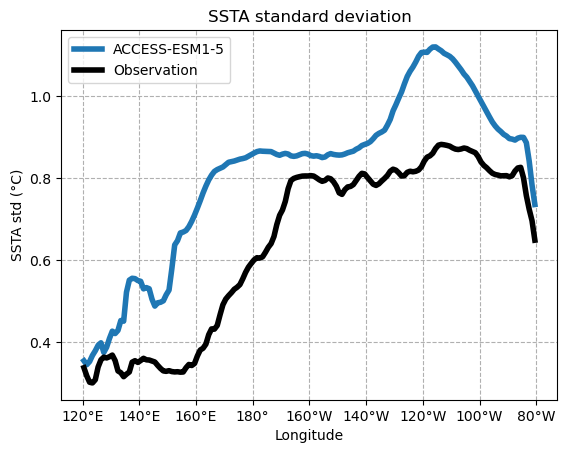

In [8]:

## diag 2 plot
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

qplt.plot(model_datasets_prep2["ACCESS-ESM1-5"], label="ACCESS-ESM1-5", linewidth=4)
qplt.plot(obs_datasets_prep2["HadISST"], color='black', label='Observation', linewidth=4)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.grid(linestyle='--')
plt.legend()


Figure 2: Zonal structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N). The figure highlights the model's tendency to overestimate maximum variability in the central equatorial Pacific and west of the dateline. The black curve represents the reference data, while the blue curve corresponds to the model output.

## Diagnostic level 3

In [9]:

model_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

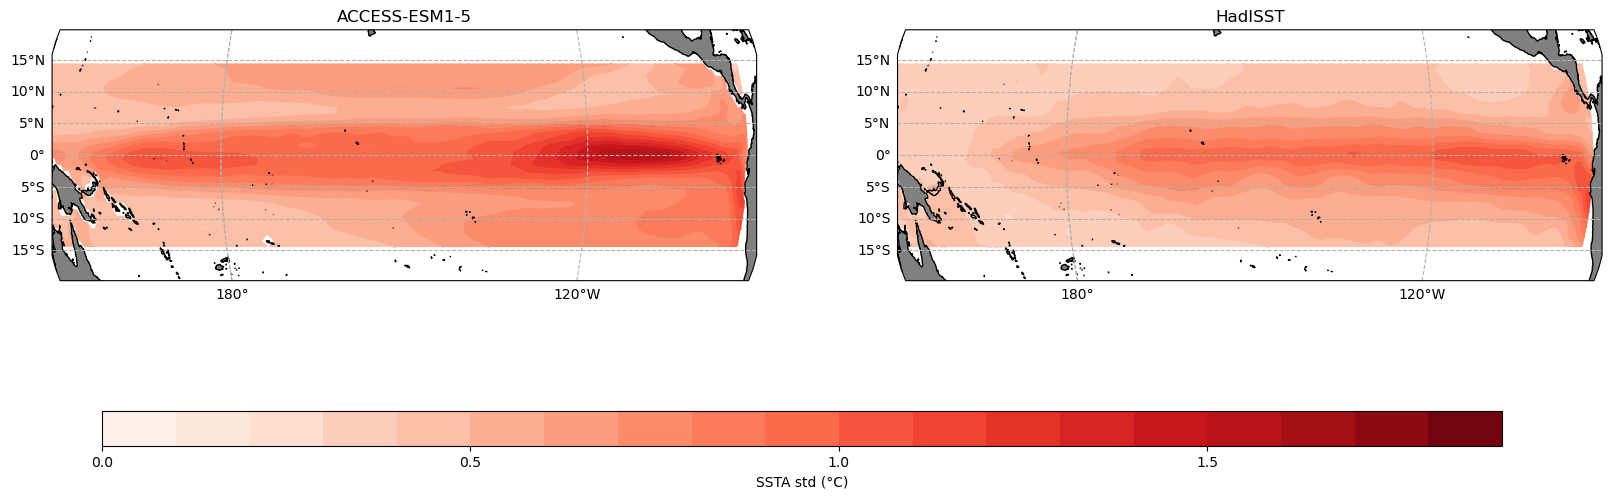

In [10]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121
process = {**model_datasets_prep3, "HadISST":obs_datasets_prep3["HadISST"]}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,2,0.1), cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,2,0.5))
cbar.set_label('SSTA std (°C)')

Figure 3: spatial structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific, showing usually a too weak variability off South America, a too strong maximum variability in the central equatorial Pacific and a too strong variability west of the dateline. The left and right maps show respectively the reference and the model.

In [11]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean
from skimage.transform import resize

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [19]:
class Visualization():
    """
    A class to generate, process, and render visualizations of geospatial data using contour plots and Lavavu.

    This class supports generating RGBA images from geospatial data, applying resizing and padding,
    handling opacity layers, and displaying results in Lavavu either as a contour field or smoothed gradient.

    Attributes:
        data (iris.cube.Cube): Input geospatial data (2D).
        size (tuple): Desired image size as (width, height).
        lat_range (tuple): Latitude range to display (min_lat, max_lat).
        lon_range (tuple): Longitude range to display (min_lon, max_lon).
        title (str): Title of the visualization.
        colormap (str or callable): Colormap used for the visualization.
        tickvalues (list): Tick values to show on colorbar.
        vmax (float): Maximum value for normalization.
        vmin (float): Minimum value for normalization.
        resolution (tuple, optional): Output resolution of the Lavavu window. Default is (700, 700).

    Methods:
        generate_rgba(): Generate RGBA image from the input data using matplotlib.
        resize_rgba(rgba, width, height): Resize an RGBA image to given dimensions.
        pad_rgba(data, pad_width, pad_height, pad_depth=None, constant_values=255): Pad an RGBA or data array.
        opacity_rgba(padded_array, opacity_array): Apply opacity to the alpha channel of an RGBA image.
        generate_lv(): Set up and configure the Lavavu Earth visualization.
        calculate_pad(): Compute the padding sizes based on latitude and longitude ranges.
        visualise_contourf(window=False): Generate and display contour visualization in Lavavu.
        visualise_gradient(window=False): Generate and display a smoothed gradient visualization in Lavavu.
    """

    
    def __init__(self, data, size, lat_range, lon_range, title, colormap, tickvalues, vmax, vmin, resolution=(700, 700)):
        self.data = data
        self.size = size
        self.width = size[0]
        self.height = size[1]
        self.title = title
        self.colormap = colormap
        self.tickvalues = tickvalues
        self.lat_range = lat_range
        self.lon_range = lon_range
        self.resolution =  resolution
        self.vmax = vmax
        self.vmin = vmin

    def generate_rgba(self):
        data = self.data.data  # 2D numpy array
        lon = self.data.coord('longitude').points
        lat = self.data.coord('latitude').points
        
        lon2d, lat2d = np.meshgrid(lon, lat)
        
        cmap = self.colormap
        norm = mcolors.Normalize(vmin=self.vmin, vmax=self.vmax)
        
        fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
        cf = ax.contourf(lon2d, lat2d, data, cmap=cmap, norm=norm, levels=20)
        ax.axis('off')
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
        fig.canvas.draw()
        rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)
    
        rgba = rgba[:, :, [1, 2, 3, 0]]
        plt.close(fig)
        
        return rgba

    def resize_rgba(self, rgba, width, height):
        #If the original image is of type uint8, it needs to be converted to float32 before resizing.
        rgba_float = rgba.astype(np.float32) / 255.0
    
        # Resize the image (while preserving the number of channels).
        rgba_resized = resize(rgba_float, (width, height, 4), preserve_range=True, anti_aliasing=True)
        
        # change back to uint8
        rgba_resized = np.clip(rgba_resized * 255, 0, 255).astype(np.uint8)
    
        return rgba_resized
        
    def pad_rgba(self, data, pad_width, pad_height, pad_depth=None, constant_values=255):
        if pad_depth:
            padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height, pad_depth),
                        mode='constant',
                        constant_values=constant_values 
            )
        else:
             padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height),  
                        mode='constant',
                        constant_values=constant_values  
            )
            
        return padded_rgba

    def opacity_rgba(self, padded_array, opacity_array):
        array = normalise_array(opacity_array)
        oarray = array
        oarray = np.nan_to_num(oarray)
        oarray = (oarray * 255).astype(np.uint8)
        padded_array[::, ::, 3] = oarray
        
        return padded_array

    def generate_lv(self):
        lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
        lv.rotation(15.0, -200.0, 0.0) #Rotate to Pacific
        lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
        lv.brightness_contrast_saturation(0.5, 0.5, 0.65)

        cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=self.tickvalues)
        cbar.colourmap(self.colormap, range=[self.vmin, self.vmax])
        lv.title(self.title)
        
        return lv

    def calculate_pad(self):
        self.pad_width = ((self.lat_range[0]-(-90))*5, (90-self.lat_range[1])*5)
        self.pad_height = (self.lon_range[0]*5, (360 - self.lon_range[1])*5)

    def visualise_contourf(self, window=False, Alpha=0.7):
        self.calculate_pad()
        rgba=self.generate_rgba()
        resized_rgba=self.resize_rgba(rgba,width=self.width,height=self.height)
        opacity_array = resize(self.data.data, self.size, order=1, preserve_range=True, anti_aliasing=True)
        padded_rgba=self.pad_rgba(resized_rgba,pad_width=self.pad_width,pad_height=self.pad_height,pad_depth=(0, 0), constant_values=0)
        padded_rgba[:,:,3]=padded_rgba[:,:,3]*Alpha

        lv = self.generate_lv()
        accessvis.update_earth_values(lv, dataMode=0, data=padded_rgba)

        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

    def visualise_gradient(self, window=False):
        lv = self.generate_lv()

        pad_width = ((self.lat_range[0]-(-90)), (90-self.lat_range[1]))
        pad_height = (self.lon_range[0], (360 - self.lon_range[1]))

        padded_data = np.pad(self.data.data, pad_width=(pad_width, pad_height), mode='constant', constant_values=0)

        smoothed = gaussian_filter(padded_data, sigma=1.0)
        colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=self.colormap, opacitymap=True, minimum=self.vmin, maximum=self.vmax)
        accessvis.update_earth_values(lv, dataMode=0, data=colours_model)
        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

In [20]:
obs_data = obs_datasets_prep3["HadISST"]
model_data = model_datasets_prep3["ACCESS-ESM1-5"]

v_model = Visualization(data=model_data, size=(150,800), lat_range=(-15, 15), lon_range=(120, 280), title="ACCESS-ESM1-5", colormap=plt.get_cmap('Reds'), tickvalues=[0.5,1.0,1.5], vmax=1.9, vmin=0)
v_obs = Visualization(data=obs_data, size=(150,800), lat_range=(-15, 15), lon_range=(120, 280), title="HadISST", colormap=plt.get_cmap('Reds'), tickvalues=[0.5,1.0,1.5], vmax=1.9, vmin=0)


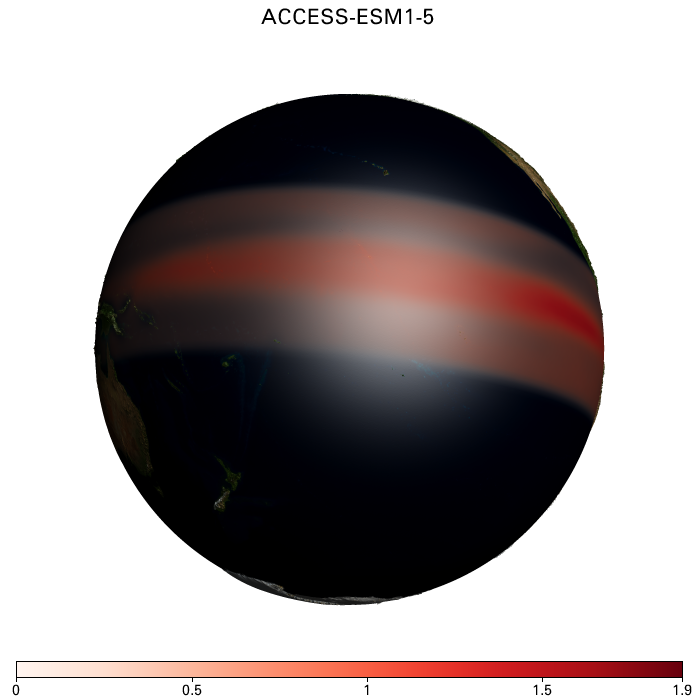

In [21]:
# specify window=True if you would like an interactive window
v_model.visualise_gradient()


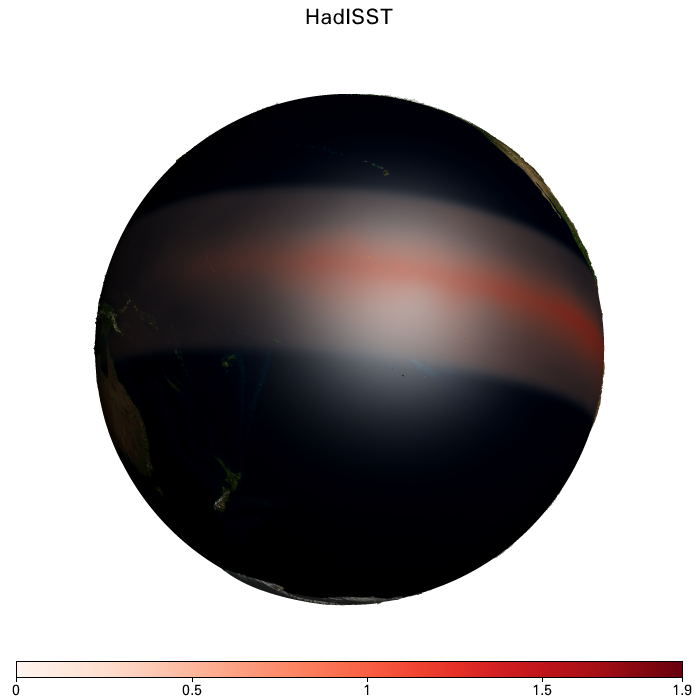

In [22]:
# specify window=True if you would like an interactive window
v_obs.visualise_gradient()


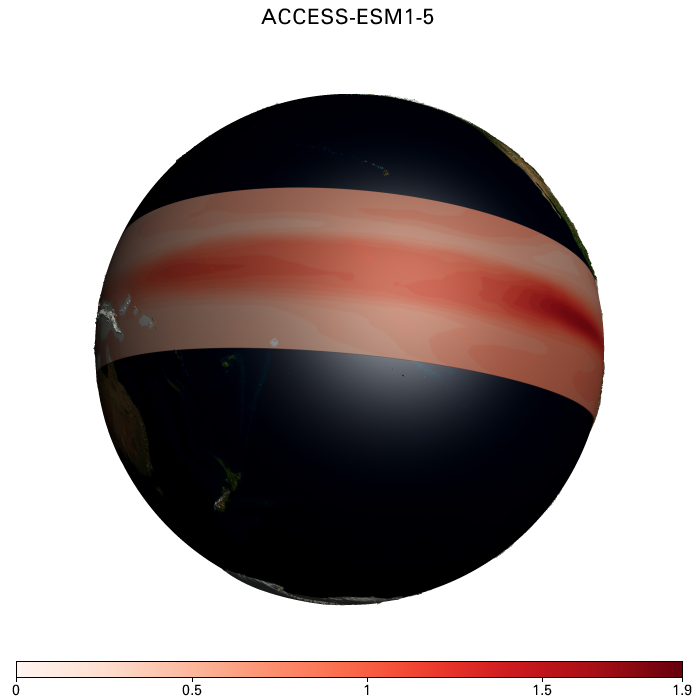

In [25]:
# specify window=True if you would like an interactive window
v_model.visualise_contourf(window=False)


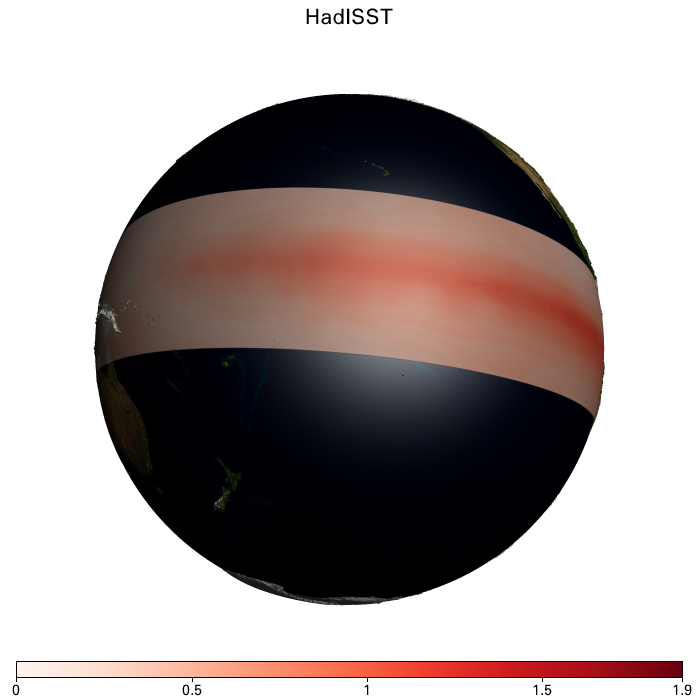

In [24]:
# specify window=True if you would like an interactive window
v_obs.visualise_contourf()